In [1]:
import findspark
findspark.init('/home/tuyen/spark-3.0.1-bin-hadoop2.7/')

In [2]:
import pandas as pd

In [3]:
from pyspark import SparkContext
from pyspark.streaming import StreamingContext
from pyspark.sql import SQLContext
from pyspark.sql.functions import desc

In [4]:
sc = SparkContext()

In [5]:
ssc = StreamingContext(sc, 100)
sqlContext = SQLContext(sc)

In [6]:
socket_stream = ssc.socketTextStream("127.0.0.1", 5555)

In [7]:
lines = socket_stream.window(200)

In [8]:
from collections import namedtuple
fields = ("tag", "count" )
Tweet = namedtuple( 'Tweet', fields )

In [9]:
( lines.flatMap( lambda text: text.split( " " ) ) #Splits to a list
  .filter( lambda word: word.lower().startswith("#") ) # Checks for hashtag calls
  .map( lambda word: ( word.lower(), 1 ) ) # Lower cases the word
  .reduceByKey( lambda a, b: a + b ) # Reduces
  .map( lambda rec: Tweet( rec[0], rec[1] ) ) # Stores in a Tweet Object
  .foreachRDD( lambda rdd: rdd.toDF().sort( desc("count") ) # Sorts Them in a DF
  .limit(50).registerTempTable("tweets") ) ) # Registers to a table.

# Now starting Tweetread.py

In [10]:
ssc.start()  

In [11]:
import time
from IPython import display
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline 

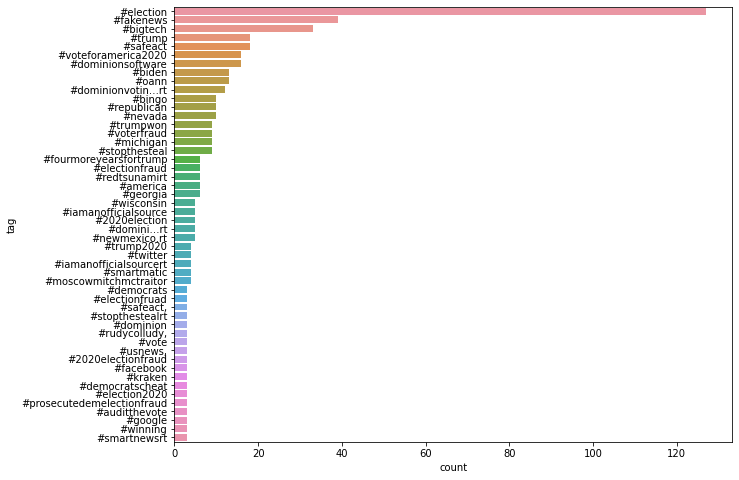

In [12]:
count = 0
while count < 50:  
    time.sleep( 3 )
    top_50_tweets = sqlContext.sql( 'Select tag, count from tweets' )
    top_50_df = top_50_tweets.toPandas()
    display.clear_output(wait=True)
    plt.figure( figsize = ( 10, 8 ) )
    sns.barplot( x="count", y="tag", data=top_50_df)
    plt.show()
    count = count + 1

In [13]:
ssc.stop()